In [2]:
# importing libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor

### Define Metric

In [3]:
def WMAE(dataset, real, predicted):
  
    weights = []
    for i in dataset['IsHoliday']:
        if i == 1:
            weights.append(5)
        else:
            weights.append(1)
    weights = np.array(weights)
    wmae = np.sum(weights*abs(real-predicted))/(np.sum(weights))
    return wmae

### Data loading

In [4]:
df = pd.read_csv("Final_data_train_FE.csv")
df = df[df['Weekly_Sales']>0]

In [5]:
df.shape

(420212, 30)

In [6]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Holiday_Type,Temperature_Cat,Fuel_Price_Cat,Holiday_Month,Week_of_the_month,weeks_for_christmas,weeks_for_thanksgiving,weeks_for_laborday,weeks_for_superbowl,no_of_weeks_for_next_holiday
0,1,1,1.265308e+09,24924.50,0,42.31,2.572,0.0,0.0,0.0,...,0,40,3.0,3,1,47,42,31,1,1
1,1,2,1.265308e+09,50605.27,0,42.31,2.572,0.0,0.0,0.0,...,0,40,3.0,3,1,47,42,31,1,1
2,1,3,1.265308e+09,13740.12,0,42.31,2.572,0.0,0.0,0.0,...,0,40,3.0,3,1,47,42,31,1,1
3,1,4,1.265308e+09,39954.04,0,42.31,2.572,0.0,0.0,0.0,...,0,40,3.0,3,1,47,42,31,1,1
4,1,5,1.265308e+09,32229.38,0,42.31,2.572,0.0,0.0,0.0,...,0,40,3.0,3,1,47,42,31,1,1


In [7]:
X = df.drop(['Weekly_Sales'], axis=1)
y = df['Weekly_Sales']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(294148, 29)
(126064, 29)
(294148,)
(126064,)


## Feature Importance

In [9]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

RandomForestRegressor()

In [10]:
feature_imp_df = pd.DataFrame()
feature_imp_df['imp_features'] = clf.feature_importances_
feature_imp_df['feature_names'] = X_train.columns
feature_imp_df = feature_imp_df.sort_values(by='imp_features', ascending=False)
feature_imp_df.head()

,imp_features,feature_names
1,0.628718,Dept
14,0.189240,Size
0,0.056911,Store
11,0.024701,CPI
25,0.023795,weeks_for_thanksgiving


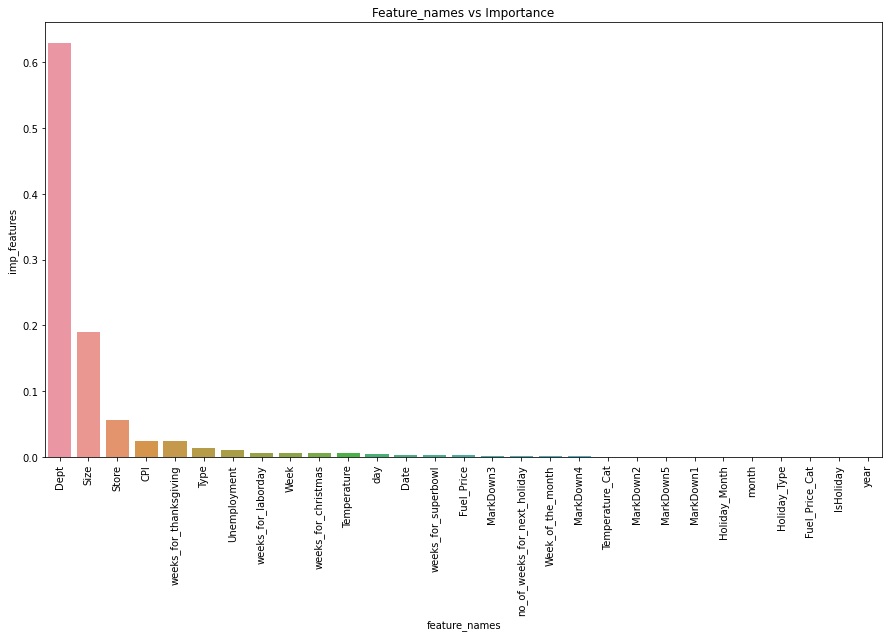

In [11]:
plt.figure(figsize=(15,8))
sns.barplot(feature_imp_df['feature_names'], feature_imp_df['imp_features'])
plt.title('Feature_names vs Importance')
plt.xticks(rotation=90)
plt.show()

In [10]:
# selecting top 10 features
X_train_top_10 = X_train[['Dept', 'Size', 'Store', 'weeks_for_thanksgiving', 'CPI', 'Type', 'Unemployment', 'weeks_for_laborday'
                         , 'Week', 'IsHoliday']]
X_test_top_10 = X_test[['Dept', 'Size', 'Store', 'weeks_for_thanksgiving', 'CPI', 'Type', 'Unemployment', 'weeks_for_laborday'
                         , 'Week', 'IsHoliday']]

# selecting top 15 features

X_train_top_15 = X_train[['Dept', 'Size', 'Store', 'weeks_for_thanksgiving', 'CPI', 'Type', 'Unemployment', 'weeks_for_laborday'
                         , 'Week', 'Temperature', 'weeks_for_christmas', 'day', 'Date', 'Fuel_Price', 'IsHoliday']]
X_test_top_15 = X_test[['Dept', 'Size', 'Store', 'weeks_for_thanksgiving', 'CPI', 'Type', 'Unemployment', 'weeks_for_laborday'
                         , 'Week', 'Temperature', 'weeks_for_christmas', 'day', 'Date', 'Fuel_Price', 'IsHoliday']]

# Filtered features 
X_train_1 = X_train[['Dept', 'Size', 'Store', 'Type', 'Week', 'day', 'IsHoliday', 'year']]
X_test_1 = X_test[['Dept', 'Size', 'Store', 'Type', 'Week', 'day', 'IsHoliday', 'year']]

## Simple Linear Regression

### Using all features

In [14]:
model1 = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
model1.fit(X_train, y_train)
predicted_train_y_lr = model1.predict(X_train)
predicted_test_y_lr = model1.predict(X_test)

wmae_train_score = WMAE(X_train, y_train, predicted_train_y_lr)
wmae_test_score = WMAE(X_test, y_test, predicted_test_y_lr)

print(wmae_train_score)
print(wmae_test_score)

14769.251083188223
14808.070520835909


### Using top 15 features

In [16]:
model1 = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
model1.fit(X_train_top_15, y_train)
predicted_train_y_lr = model1.predict(X_train_top_15)
predicted_test_y_lr = model1.predict(X_test_top_15)

wmae_train_score = WMAE(X_train_top_15, y_train, predicted_train_y_lr)
wmae_test_score = WMAE(X_test_top_15, y_test, predicted_test_y_lr)

print(wmae_train_score)
print(wmae_test_score)

14801.28715452829
14836.594884037866


### Using top 10 features

In [17]:
model1 = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
model1.fit(X_train_top_10, y_train)
predicted_train_y_lr = model1.predict(X_train_top_10)
predicted_test_y_lr = model1.predict(X_test_top_10)

wmae_train_score = WMAE(X_train_top_10, y_train, predicted_train_y_lr)
wmae_test_score = WMAE(X_test_top_10, y_test, predicted_test_y_lr)

print(wmae_train_score)
print(wmae_test_score)

14806.418349922193
14846.624473955824


### Using filtered features

In [35]:
model1 = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
model1.fit(X_train_1, y_train)
predicted_train_y = model1.predict(X_train_1)
predicted_test_y = model1.predict(X_test_1)

wmae_train_score = WMAE(X_train_1, y_train, predicted_train_y)
wmae_test_score = WMAE(X_test_1, y_test, predicted_test_y)

print(wmae_train_score)
print(wmae_test_score)

14808.218694520228
14850.005584504932


## XG Boost

### 1. XGBoost using all features

In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [11]:
xgb_model = XGBRegressor()
parameters = {'learning_rate':[0.05, 0.1,0.2,0.4],
              'n_estimators':[800, 1000, 1200, 1400, 1600, 1800, 2000],
              'max_depth':[8, 10, 12, 14]}
clf = RandomizedSearchCV(xgb_model, parameters, cv=3, n_jobs=-1, return_train_score=True)
clf.fit(X_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                       

In [12]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,833.382929,4.810661,3.753899,0.512152,800,10,0.2,"{'n_estimators': 800, 'max_depth': 10, 'learni...",0.977131,0.981052,0.979044,0.979076,0.001601,3,0.999172,0.999164,0.999139,0.999159,1.413032e-05
1,2750.033598,397.120028,13.328707,2.227661,1600,10,0.05,"{'n_estimators': 1600, 'max_depth': 10, 'learn...",0.976881,0.980240,0.979768,0.978963,0.001485,4,0.997282,0.997390,0.997462,0.997378,7.394887e-05
2,5694.589475,284.695656,20.425208,5.662587,1600,14,0.1,"{'n_estimators': 1600, 'max_depth': 14, 'learn...",0.975698,0.978155,0.977969,0.977274,0.001117,6,0.999993,0.999992,0.999994,0.999993,5.610977e-07
3,2035.561921,63.297330,5.661052,1.844566,1400,8,0.2,"{'n_estimators': 1400, 'max_depth': 8, 'learni...",0.978192,0.982044,0.978880,0.979705,0.001677,1,0.997983,0.997965,0.997941,0.997963,1.704948e-05
4,1314.363051,82.309911,4.284361,0.041704,800,12,0.4,"{'n_estimators': 800, 'max_depth': 12, 'learni...",0.975614,0.979071,0.974866,0.976517,0.001832,8,0.999995,0.999995,0.999995,0.999995,2.535044e-07


In [13]:
clf.best_params_

{'n_estimators': 1400, 'max_depth': 8, 'learning_rate': 0.2}

In [17]:
model2 = XGBRegressor(learning_rate=0.2, n_estimators=1400, max_depth=8, n_jobs=-1)
model2.fit(X_train, y_train)
predicted_train_y_xg = model2.predict(X_train)
predicted_test_y_xg = model2.predict(X_test)

wmae_train_score = WMAE(X_train, y_train, predicted_train_y_xg)
wmae_test_score = WMAE(X_test, y_test, predicted_test_y_xg)

print(wmae_train_score)
print(wmae_test_score)

752.7506993229604
1514.5331793397615


### 2. XGBoost using top 15 features

In [37]:
model2 = XGBRegressor(learning_rate=0.2, n_estimators=1400, max_depth=8, n_jobs=-1)
model2.fit(X_train_top_15, y_train)
predicted_train_y_xg = model2.predict(X_train_top_15)
predicted_test_y_xg = model2.predict(X_test_top_15)

wmae_train_score = WMAE(X_train_top_15, y_train, predicted_train_y_xg)
wmae_test_score = WMAE(X_test_top_15, y_test, predicted_test_y_xg)

print(wmae_train_score)
print(wmae_test_score)

1014.5588627317001
1513.895236320939


### XGBoost Using top 10 features

In [38]:
model2 = XGBRegressor(learning_rate=0.2, n_estimators=1400, max_depth=8, n_jobs=-1)
model2.fit(X_train_top_10, y_train)
predicted_train_y_xg = model2.predict(X_train_top_10)
predicted_test_y_xg = model2.predict(X_test_top_10)

wmae_train_score = WMAE(X_train_top_10, y_train, predicted_train_y_xg)
wmae_test_score = WMAE(X_test_top_10, y_test, predicted_test_y_xg)

print(wmae_train_score)
print(wmae_test_score)

1094.3024053864585
1546.5289738750078


### Using filtered features

In [39]:
model1 = XGBRegressor(learning_rate=0.2, n_estimators=1400, max_depth=8, n_jobs=-1)
model1.fit(X_train_1, y_train)
predicted_train_y = model1.predict(X_train_1)
predicted_test_y = model1.predict(X_test_1)

wmae_train_score = WMAE(X_train_1, y_train, predicted_train_y)
wmae_test_score = WMAE(X_test_1, y_test, predicted_test_y)

print(wmae_train_score)
print(wmae_test_score)

997.0493221976978
1383.3333086570542


## RandomForest

### Using all features

In [40]:
rf_model = RandomForestRegressor()
parameters = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90],
              'n_estimators': [20, 50, 100, 150, 200, 250, 300, 350]}
clf = RandomizedSearchCV(rf_model, parameters, cv=3, n_jobs=-1, return_train_score=True)
clf.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90],
                                        'n_estimators': [20, 50, 100, 150, 200,
                                                         250, 300, 350]},
                   return_train_score=True)

In [41]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,839.222353,0.974664,4.921120,0.044108,350,10,"{'n_estimators': 350, 'max_depth': 10}",0.891042,0.892151,0.887730,0.890308,0.001878,10,0.902581,0.898347,0.898981,0.899970,0.001865
1,248.602016,0.794496,4.323979,0.042362,50,90,"{'n_estimators': 50, 'max_depth': 90}",0.970187,0.975283,0.970993,0.972155,0.002237,6,0.996237,0.995930,0.996202,0.996123,0.000137
2,1475.259818,2.888146,47.338790,2.926575,300,50,"{'n_estimators': 300, 'max_depth': 50}",0.970625,0.975849,0.971435,0.972636,0.002295,2,0.996463,0.996266,0.996585,0.996438,0.000131
3,739.759503,15.808483,15.440308,6.133861,150,80,"{'n_estimators': 150, 'max_depth': 80}",0.970320,0.975630,0.971309,0.972420,0.002306,5,0.996379,0.996214,0.996507,0.996366,0.000120
4,1702.294283,5.213811,102.687902,0.739872,350,70,"{'n_estimators': 350, 'max_depth': 70}",0.970502,0.976143,0.971720,0.972788,0.002424,1,0.996444,0.996129,0.996644,0.996406,0.000212
5,502.123136,16.433412,15.705079,11.612402,100,90,"{'n_estimators': 100, 'max_depth': 90}",0.970131,0.975240,0.971060,0.972144,0.002222,7,0.996331,0.996100,0.996522,0.996318,0.000173
6,1706.806862,5.775286,103.073727,1.198381,350,50,"{'n_estimators': 350, 'max_depth': 50}",0.970623,0.975830,0.971400,0.972618,0.002293,3,0.996371,0.996237,0.996551,0.996386,0.000129
7,96.024386,0.342404,1.564004,0.033081,20,60,"{'n_estimators': 20, 'max_depth': 60}",0.968880,0.974518,0.970568,0.971322,0.002363,8,0.995676,0.995622,0.995833,0.995710,0.000090
8,96.245807,0.401963,1.533777,0.025888,20,90,"{'n_estimators': 20, 'max_depth': 90}",0.968467,0.973674,0.970537,0.970893,0.002141,9,0.995380,0.995433,0.995707,0.995507,0.000144
9,774.252783,187.698107,14.597935,4.416748,200,60,"{'n_estimators': 200, 'max_depth': 60}",0.970775,0.975642,0.971284,0.972567,0.002184,4,0.996412,0.996104,0.996550,0.996355,0.000186


In [42]:
clf.best_params_

{'n_estimators': 350, 'max_depth': 70}

In [43]:
model1 = RandomForestRegressor(n_estimators=350, max_depth=70, n_jobs=-1)
model1.fit(X_train, y_train)
predicted_train_y_xg = model1.predict(X_train)
predicted_test_y_xg = model1.predict(X_test)

wmae_train_score = WMAE(X_train, y_train, predicted_train_y_xg)
wmae_test_score = WMAE(X_test, y_test, predicted_test_y_xg)

print(wmae_train_score)
print(wmae_test_score)

557.0921825113841
1490.3441407565933


### Using top 15 features

In [44]:
model1 = RandomForestRegressor(n_estimators=350, max_depth=70, n_jobs=-1)

model1.fit(X_train_top_15, y_train)
predicted_train_y_xg = model1.predict(X_train_top_15)
predicted_test_y_xg = model1.predict(X_test_top_15)

wmae_train_score = WMAE(X_train_top_15, y_train, predicted_train_y_xg)
wmae_test_score = WMAE(X_test_top_15, y_test, predicted_test_y_xg)

print(wmae_train_score)
print(wmae_test_score)

550.2243057598372
1475.7740175452664


### Using top 10 features

In [45]:
model1 = RandomForestRegressor(n_estimators=350, max_depth=70, n_jobs=-1)

model1.fit(X_train_top_10, y_train)
predicted_train_y_xg = model1.predict(X_train_top_10)
predicted_test_y_xg = model1.predict(X_test_top_10)

wmae_train_score = WMAE(X_train_top_10, y_train, predicted_train_y_xg)
wmae_test_score = WMAE(X_test_top_10, y_test, predicted_test_y_xg)

print(wmae_train_score)
print(wmae_test_score)

590.7215615014725
1570.2021972566195


### Using base features

In [51]:
model1 = RandomForestRegressor(n_estimators=350, max_depth=70, n_jobs=-1)

model1.fit(X_train_1, y_train)

predicted_train_y_xg = model1.predict(X_train_1)
predicted_test_y_xg = model1.predict(X_test_1)

wmae_train_score = WMAE(X_train_1, y_train, predicted_train_y_xg)
wmae_test_score = WMAE(X_test_1, y_test, predicted_test_y_xg)

print(wmae_train_score)
print(wmae_test_score)

538.9341730629383
1443.1361675272476


## Decision Tree

### 1. Using all features

In [53]:
dt_model = DecisionTreeRegressor()
parameters = {'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24], 'min_samples_leaf': [5, 10, 20, 50, 60, 70, 80]}
clf = RandomizedSearchCV(dt_model, parameters, cv=3, n_jobs=-1, return_train_score=True)
clf.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      16, 18, 20, 22, 24],
                                        'min_samples_leaf': [5, 10, 20, 50, 60,
                                                             70, 80]},
                   return_train_score=True)

In [54]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,6.137046,0.061112,0.071949,0.009471,10,16,"{'min_samples_leaf': 10, 'max_depth': 16}",0.949916,0.954380,0.949980,0.951425,0.002090,3,0.967008,0.966971,0.967778,0.967253,0.000372
1,2.464724,0.079846,0.060887,0.020621,80,6,"{'min_samples_leaf': 80, 'max_depth': 6}",0.703024,0.706514,0.702259,0.703932,0.001852,10,0.704929,0.703095,0.705262,0.704428,0.000953
2,4.617889,0.037820,0.071840,0.004079,70,12,"{'min_samples_leaf': 70, 'max_depth': 12}",0.891551,0.895063,0.891454,0.892689,0.001679,9,0.898880,0.899147,0.896486,0.898171,0.001197
3,6.379871,0.092344,0.071586,0.001343,10,18,"{'min_samples_leaf': 10, 'max_depth': 18}",0.953105,0.957124,0.952868,0.954366,0.001952,2,0.971889,0.971347,0.971823,0.971686,0.000242
4,4.975318,0.057883,0.051898,0.009629,70,14,"{'min_samples_leaf': 70, 'max_depth': 14}",0.904731,0.908558,0.903838,0.905709,0.002047,7,0.913189,0.912914,0.909460,0.911854,0.001697
5,5.355738,0.054817,0.065971,0.003717,70,22,"{'min_samples_leaf': 70, 'max_depth': 22}",0.909907,0.914455,0.909334,0.911232,0.002291,6,0.919064,0.918866,0.915200,0.917710,0.001776
6,6.308040,0.036465,0.070656,0.012416,20,24,"{'min_samples_leaf': 20, 'max_depth': 24}",0.948939,0.956861,0.945978,0.950593,0.004594,4,0.962264,0.961069,0.959244,0.960859,0.001242
7,5.674534,0.020851,0.065888,0.004394,60,20,"{'min_samples_leaf': 60, 'max_depth': 20}",0.921510,0.923953,0.917096,0.920853,0.002838,5,0.930853,0.927705,0.926800,0.928453,0.001737
8,6.748759,0.156375,0.082106,0.009948,5,20,"{'min_samples_leaf': 5, 'max_depth': 20}",0.952893,0.959531,0.953606,0.955343,0.002976,1,0.982844,0.982942,0.983171,0.982986,0.000137
9,4.005165,0.300561,0.047530,0.011274,50,12,"{'min_samples_leaf': 50, 'max_depth': 12}",0.902636,0.906093,0.899284,0.902671,0.002780,8,0.909785,0.912466,0.907685,0.909979,0.001957


In [55]:
clf.best_params_

{'min_samples_leaf': 5, 'max_depth': 20}

In [56]:
dt_model = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
dt_model.fit(X_train_top_15, y_train)
predicted_train_y_dt = dt_model.predict(X_train_top_15)
predicted_test_y_dt = dt_model.predict(X_test_top_15)

wmae_train_score = WMAE(X_train_top_15, y_train, predicted_train_y_dt)
wmae_test_score = WMAE(X_test_top_15, y_test, predicted_test_y_dt)

print(wmae_train_score)
print(wmae_test_score)

1246.740233168148
1874.1961765436438


### Using top 15 features

In [57]:
model1 = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
model1.fit(X_train_top_15, y_train)
predicted_train_y_xg = model1.predict(X_train_top_15)
predicted_test_y_xg = model1.predict(X_test_top_15)

wmae_train_score = WMAE(X_train_top_15, y_train, predicted_train_y_xg)
wmae_test_score = WMAE(X_test_top_15, y_test, predicted_test_y_xg)

print(wmae_train_score)
print(wmae_test_score)

1246.7402863078435
1872.8570442435794


### Using top 10 features

In [58]:
model1 = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
model1.fit(X_train_top_10, y_train)
predicted_train_y_xg = model1.predict(X_train_top_10)
predicted_test_y_xg = model1.predict(X_test_top_10)

wmae_train_score = WMAE(X_train_top_10, y_train, predicted_train_y_xg)
wmae_test_score = WMAE(X_test_top_10, y_test, predicted_test_y_xg)

print(wmae_train_score)
print(wmae_test_score)

1380.9567359227124
1923.7712081401228


### Using filtered features

In [52]:
model1 = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)

model1.fit(X_train_1, y_train)

predicted_train_y = model1.predict(X_train_1)
predicted_test_y = model1.predict(X_test_1)

wmae_train_score = WMAE(X_train_1, y_train, predicted_train_y)
wmae_test_score = WMAE(X_test_1, y_test, predicted_test_y)

print(wmae_train_score)
print(wmae_test_score)

1366.044299612273
1837.371056278631


## LightGBM

### Using all features

In [49]:
from lightgbm import LGBMRegressor

In [25]:
lgb = LGBMRegressor()
parameters = {'learning_rate':[0.05,0.1,0.2,0.4,0.6,0.8,0.9,1],
              'n_estimators':[1000,1500,2000,2500,3000,3500, 4000, 4500, 5000, 5500],
              'max_depth':[10, 20, 25, 30, 35, 40, 45, 50]}
clf = RandomizedSearchCV(lgb, parameters, cv=3, n_jobs=-1, return_train_score=True)
clf.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.4,
                                                          0.6, 0.8, 0.9, 1],
                                        'max_depth': [10, 20, 25, 30, 35, 40,
                                                      45, 50],
                                        'n_estimators': [1000, 1500, 2000, 2500,
                                                         3000, 3500, 4000, 4500,
                                                         5000, 5500]},
                   return_train_score=True)

In [26]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,215.246559,7.737034,163.262813,4.312923,4000,35,0.4,"{'n_estimators': 4000, 'max_depth': 35, 'learn...",0.975981,0.979445,0.976725,0.977384,0.001489,3,0.997150,0.997179,0.997116,0.997148,0.000026
1,266.784028,9.722050,211.605802,6.375894,5000,35,0.2,"{'n_estimators': 5000, 'max_depth': 35, 'learn...",0.978150,0.982526,0.980351,0.980342,0.001787,1,0.996129,0.996267,0.996177,0.996191,0.000057
2,181.304310,0.070137,120.501982,23.793307,3500,50,0.8,"{'n_estimators': 3500, 'max_depth': 50, 'learn...",0.966343,0.970613,0.968696,0.968551,0.001746,6,0.997438,0.997471,0.997417,0.997442,0.000022
3,133.734575,1.270703,85.848535,14.440890,2500,30,0.9,"{'n_estimators': 2500, 'max_depth': 30, 'learn...",0.962707,0.967387,0.965848,0.965314,0.001947,9,0.995972,0.996241,0.996013,0.996076,0.000119
4,186.118239,1.011334,112.175626,14.870098,3500,50,0.9,"{'n_estimators': 3500, 'max_depth': 50, 'learn...",0.962777,0.967350,0.965824,0.965317,0.001901,8,0.997348,0.997501,0.997348,0.997399,0.000072
5,281.355585,2.158725,220.980690,3.834198,5500,40,0.9,"{'n_estimators': 5500, 'max_depth': 40, 'learn...",0.962822,0.967354,0.965764,0.965313,0.001878,10,0.998631,0.998702,0.998630,0.998654,0.000033
6,131.187912,3.210882,86.796030,9.605973,2500,50,0.8,"{'n_estimators': 2500, 'max_depth': 50, 'learn...",0.966365,0.970460,0.968526,0.968450,0.001673,7,0.996207,0.996231,0.996164,0.996200,0.000028
7,283.121810,0.420064,230.497192,6.406375,5500,10,0.6,"{'n_estimators': 5500, 'max_depth': 10, 'learn...",0.972102,0.975891,0.974888,0.974293,0.001603,5,0.998301,0.998427,0.998380,0.998369,0.000052
8,260.840468,0.986761,201.229384,12.278226,5000,45,0.2,"{'n_estimators': 5000, 'max_depth': 45, 'learn...",0.978150,0.982526,0.980351,0.980342,0.001787,1,0.996129,0.996267,0.996177,0.996191,0.000057
9,126.847659,9.009055,62.612458,3.537797,2500,20,0.4,"{'n_estimators': 2500, 'max_depth': 20, 'learn...",0.975477,0.978967,0.976166,0.976870,0.001509,4,0.995495,0.995271,0.995429,0.995398,0.000094


In [27]:
clf.best_params_

{'n_estimators': 5000, 'max_depth': 35, 'learning_rate': 0.2}

In [34]:
model1 = LGBMRegressor(learning_rate=0.2, n_estimators=5000, max_depth=35, n_jobs=-1)
model1.fit(X_train, y_train)
predicted_train_y_lg = model1.predict(X_train)
predicted_test_y_lg = model1.predict(X_test)

wmae_train_score = WMAE(X_train, y_train, predicted_train_y_lg)
wmae_test_score = WMAE(X_test, y_test, predicted_test_y_lg)

print(wmae_train_score)
print(wmae_test_score)

950.5435732228202
1540.4594370930226


### Using top 15 features

In [35]:
model2 = LGBMRegressor(learning_rate=0.2, n_estimators=5000, max_depth=25, n_jobs=-1)
model2.fit(X_train_top_15, y_train)
predicted_train_y_lg = model2.predict(X_train_top_15)
predicted_test_y_lg = model2.predict(X_test_top_15)

wmae_train_score = WMAE(X_train_top_15, y_train, predicted_train_y_lg)
wmae_test_score = WMAE(X_test_top_15, y_test, predicted_test_y_lg)

print(wmae_train_score)
print(wmae_test_score)

943.3189612909164
1477.9503448090663


### Using top 10 features

In [38]:
model3 = LGBMRegressor(learning_rate=0.2, n_estimators=5000, max_depth=35, n_jobs=-1)
model3.fit(X_train_top_10, y_train)
predicted_train_y_lg = model3.predict(X_train_top_10)
predicted_test_y_lg = model3.predict(X_test_top_10)

wmae_train_score = WMAE(X_train_top_10, y_train, predicted_train_y_lg)
wmae_test_score = WMAE(X_test_top_10, y_test, predicted_test_y_lg)

print(wmae_train_score)
print(wmae_test_score)

1052.3838054513385
1516.137527273821


### Using filtered features

In [55]:
model1 = LGBMRegressor(learning_rate=0.2, n_estimators=5000, max_depth=35, n_jobs=-1)

model1.fit(X_train_1, y_train)

predicted_train_y = model1.predict(X_train_1)
predicted_test_y = model1.predict(X_test_1)

wmae_train_score = WMAE(X_train_1, y_train, predicted_train_y)
wmae_test_score = WMAE(X_test_1, y_test, predicted_test_y)

print(wmae_train_score)
print(wmae_test_score)

1014.2680017032712
1402.0126246332375


# Stacking

In [54]:
from sklearn.ensemble import StackingRegressor

## Using all features

In [51]:
estimators = [('xg', XGBRegressor(learning_rate=0.1, n_estimators=2200, max_depth=8, n_jobs=-1)),
             ('dt', DecisionTreeRegressor(max_depth=22, min_samples_leaf=10)),
             ('lgb', LGBMRegressor(learning_rate=0.2, n_estimators=5000, max_depth=25, n_jobs=-1)),
             ('rf', RandomForestRegressor(n_estimators=170, max_depth=25, n_jobs=-1))]
model1 = StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor())
model1.fit(X_train,y_train)

predicted_train_y = model1.predict(X_train)
predicted_test_y = model1.predict(X_test)

wmae_train_score = WMAE(X_train, y_train, predicted_train_y)
wmae_test_score = WMAE(X_test, y_test, predicted_test_y)

print(wmae_train_score)
print(wmae_test_score)

691.8736423034042
1281.989518963769


## Using top 15 features

In [50]:
estimators = [('xg', XGBRegressor(learning_rate=0.1, n_estimators=2200, max_depth=8, n_jobs=-1)),
             ('dt', DecisionTreeRegressor(max_depth=22, min_samples_leaf=10)),
             ('lgb', LGBMRegressor(learning_rate=0.2, n_estimators=5000, max_depth=25, n_jobs=-1)),
             ('rf', RandomForestRegressor(n_estimators=170, max_depth=25, n_jobs=-1))]
model = StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor())
model.fit(X_train_top_15,y_train)

predicted_train_y = model.predict(X_train_top_15)
predicted_test_y = model.predict(X_test_top_15)

wmae_train_score = WMAE(X_train_top_15, y_train, predicted_train_y)
wmae_test_score = WMAE(X_test_top_15, y_test, predicted_test_y)

print(wmae_train_score)
print(wmae_test_score)

685.5844314179002
1252.602076401632


## Using top 10 features

In [52]:
estimators = [('xg', XGBRegressor(learning_rate=0.1, n_estimators=2200, max_depth=8, n_jobs=-1)),
             ('dt', DecisionTreeRegressor(max_depth=22, min_samples_leaf=10)),
             ('lgb', LGBMRegressor(learning_rate=0.2, n_estimators=5000, max_depth=25, n_jobs=-1)),
             ('rf', RandomForestRegressor(n_estimators=170, max_depth=25, n_jobs=-1))]
model2 = StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor())
model2.fit(X_train_top_10,y_train)

predicted_train_y = model2.predict(X_train_top_10)
predicted_test_y = model2.predict(X_test_top_10)

wmae_train_score = WMAE(X_train_top_10, y_train, predicted_train_y)
wmae_test_score = WMAE(X_test_top_10, y_test, predicted_test_y)

print(wmae_train_score)
print(wmae_test_score)

803.9905930456159
1319.101195503277


### Using filtered features

In [56]:
estimators = [('xg', XGBRegressor(learning_rate=0.1, n_estimators=2200, max_depth=8, n_jobs=-1)),
             ('dt', DecisionTreeRegressor(max_depth=22, min_samples_leaf=10)),
             ('lgb', LGBMRegressor(learning_rate=0.2, n_estimators=5000, max_depth=25, n_jobs=-1)),
             ('rf', RandomForestRegressor(n_estimators=170, max_depth=25, n_jobs=-1))]
model1 = StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor())
model1.fit(X_train_1, y_train)

predicted_train_y = model1.predict(X_train_1)
predicted_test_y = model1.predict(X_test_1)

wmae_train_score = WMAE(X_train_1, y_train, predicted_train_y)
wmae_test_score = WMAE(X_test_1, y_test, predicted_test_y)

print(wmae_train_score)
print(wmae_test_score)

737.0604827013741
1228.321004233956


# Table of model vs scores

In [57]:
from prettytable import PrettyTable
  
columns = ["Model", "Using all features", "Using top 10 features", "Using top 15 features", "Using filtered features"]
  
table = PrettyTable()

table.add_column(columns[0], ['Simple Linear Reg.', 'Decision Tree Reg.', 'LGBM Reg.', 'RandomForest Reg.', 'XGBoost Reg.', 'Stacking Reg.'])
table.add_column(columns[1], [14808.07, 1874.19, 1540.45, 1490.34, 1514.53, 1281.98])
table.add_column(columns[2], [14846.62, 1928.77, 1516.13, 1570.20, 1546.52, 1319.10])
table.add_column(columns[3], [14836.59, 1872.85, 1477.95, 1475.77, 1413.89, 1252.60])
table.add_column(columns[4], [14850.01, 1837.37, 1402.01, 1443.13, 1383.33, 1228.32])
  
print(table)

+--------------------+--------------------+-----------------------+-----------------------+-------------------------+
|       Model        | Using all features | Using top 10 features | Using top 15 features | Using filtered features |
+--------------------+--------------------+-----------------------+-----------------------+-------------------------+
| Simple Linear Reg. |      14808.07      |        14846.62       |        14836.59       |         14850.01        |
| Decision Tree Reg. |      1874.19       |        1928.77        |        1872.85        |         1837.37         |
|     LGBM Reg.      |      1540.45       |        1516.13        |        1477.95        |         1402.01         |
| RandomForest Reg.  |      1490.34       |         1570.2        |        1475.77        |         1443.13         |
|    XGBoost Reg.    |      1514.53       |        1546.52        |        1413.89        |         1383.33         |
|   Stacking Reg.    |      1281.98       |         1319

#### After comparing here, stacking model works well on cv data but kaggle score is lowest in case of Random Forest Regressor because Random Forest handles outliers very well. So, final model is Random Forest.

# Submission and final model

In [11]:
final_model = RandomForestRegressor(n_estimators=350, max_depth=70, n_jobs=-1)

final_model.fit(X_train_1, y_train)

joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']

In [7]:
# Importing final submission file
df = pd.read_csv('Raw data/sampleSubmission.csv')

In [8]:
df.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0


In [9]:
df.shape

(115064, 2)

In [10]:
#Importing train and test data
train_data = pd.read_csv('Final_data_train_FE.csv')
test_data = pd.read_csv('Test_data_final.csv')

In [11]:
train_data= train_data[train_data['Weekly_Sales']>0]

In [12]:
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Holiday_Type,Temperature_Cat,Fuel_Price_Cat,Holiday_Month,Week_of_the_month,weeks_for_christmas,weeks_for_thanksgiving,weeks_for_laborday,weeks_for_superbowl,no_of_weeks_for_next_holiday
0,1,1,1.265308e+09,24924.50,0,42.31,2.572,0.0,0.0,0.0,...,0,40,3.0,3,1,47,42,31,1,1
1,1,2,1.265308e+09,50605.27,0,42.31,2.572,0.0,0.0,0.0,...,0,40,3.0,3,1,47,42,31,1,1
2,1,3,1.265308e+09,13740.12,0,42.31,2.572,0.0,0.0,0.0,...,0,40,3.0,3,1,47,42,31,1,1
3,1,4,1.265308e+09,39954.04,0,42.31,2.572,0.0,0.0,0.0,...,0,40,3.0,3,1,47,42,31,1,1
4,1,5,1.265308e+09,32229.38,0,42.31,2.572,0.0,0.0,0.0,...,0,40,3.0,3,1,47,42,31,1,1


In [13]:
train_data.shape

(420212, 30)

In [14]:
test_data.drop('Unnamed: 0', axis=1, inplace=True)

In [15]:
test_data.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Holiday_Type,Temperature_Cat,Fuel_Price_Cat,Holiday_Month,Week_of_the_month,weeks_for_christmas,weeks_for_thanksgiving,weeks_for_laborday,weeks_for_superbowl,no_of_weeks_for_next_holiday
0,1,1,1.351814e+09,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,...,0,60,3.5,2,1,8,3,45,15,3
1,1,2,1.351814e+09,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,...,0,60,3.5,2,1,8,3,45,15,3
2,1,3,1.351814e+09,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,...,0,60,3.5,2,1,8,3,45,15,3
3,1,4,1.351814e+09,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,...,0,60,3.5,2,1,8,3,45,15,3
4,1,5,1.351814e+09,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,...,0,60,3.5,2,1,8,3,45,15,3


In [16]:
dates = []
for i in test_data['Date']:
  x = datetime.datetime.fromtimestamp(i).strftime('%Y-%m-%d')
  dates.append(x)
test_data['Date'] = dates

In [17]:
test_data.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Holiday_Type,Temperature_Cat,Fuel_Price_Cat,Holiday_Month,Week_of_the_month,weeks_for_christmas,weeks_for_thanksgiving,weeks_for_laborday,weeks_for_superbowl,no_of_weeks_for_next_holiday
0,1,1,2012-11-02,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,...,0,60,3.5,2,1,8,3,45,15,3
1,1,2,2012-11-02,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,...,0,60,3.5,2,1,8,3,45,15,3
2,1,3,2012-11-02,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,...,0,60,3.5,2,1,8,3,45,15,3
3,1,4,2012-11-02,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,...,0,60,3.5,2,1,8,3,45,15,3
4,1,5,2012-11-02,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,...,0,60,3.5,2,1,8,3,45,15,3


In [18]:
final_train_data = train_data[['Dept', 'Size', 'Store', 'Type', 'Week', 'day', 'IsHoliday', 'year', 'Date']]
final_test_data = test_data[['Dept', 'Size', 'Store', 'Type', 'Week', 'day', 'IsHoliday', 'year', 'Date']]
y_train = train_data['Weekly_Sales']
final_test_data = final_test_data.sort_values(by=['Store', 'Dept', 'Date'])

In [19]:
final_test_data.drop('Date', axis=1, inplace=True)
final_train_data.drop('Date', axis=1, inplace=True)

In [20]:
final_test_data.head()

,Dept,Size,Store,Type,Week,day,IsHoliday,year
0,1,151315,1,1,44,2,0,2012
71,1,151315,1,1,45,9,0,2012
142,1,151315,1,1,46,16,0,2012
213,1,151315,1,1,47,23,1,2012
285,1,151315,1,1,48,30,0,2012


In [21]:
final_model = RandomForestRegressor(n_estimators=350, max_depth=70, n_jobs=-1)
final_model.fit(final_train_data,y_train)

RandomForestRegressor(max_depth=70, n_estimators=350, n_jobs=-1)

In [22]:
joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']

In [28]:
prediction = final_model.predict(final_test_data)

In [29]:
df['Weekly_Sales'] = list(prediction)

In [30]:
df.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,35332.883343
1,1_1_2012-11-09,20056.102571
2,1_1_2012-11-16,19314.879429
3,1_1_2012-11-23,20508.560314
4,1_1_2012-11-30,27922.329714


In [31]:
df.to_csv('Submission.csv', index=None)

## Kaggle Score

In [1]:
from PIL import Image

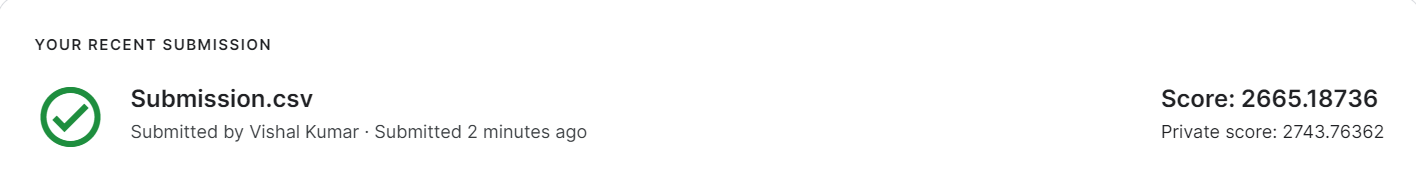

In [4]:
# https://www.geeksforgeeks.org/working-images-python/#:~:text=try%3A-,img%C2%A0%20%3D%20Image.open(path),-except%20IOError%3A

img  = Image.open('Kaggle Score.PNG')
img

## Deployment

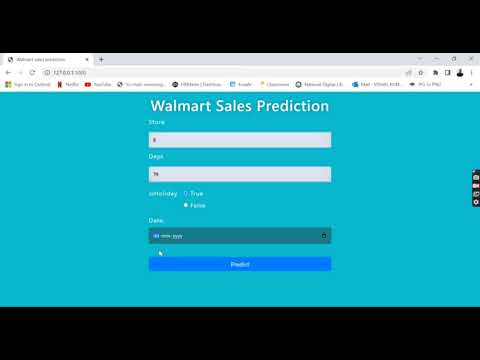

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('e1twyn-sYgs', width=800, height=300)